Cross Time Sampling
===

Sampling from April 2014 (start of the training data period) to December 2019.

A sample is generated for each month. (n=50000)

Each sample is saved in a mock json file to be used for `revscoring extract`.

Then, `revscoring extract` and `revscoring dump` are used to generate TSV feature files for each of the samples.

Note that each section of this notebook is designed to be run independently, with no dependencies from other sections other than this intro section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [4]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [5]:
working_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [6]:
start_date = datetime.fromisoformat('2014-01-01')
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01')
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1388556000, 1577858400)

### Load in all revisions

This is a 29GB text file!

We load it in, before sorting and filtering it and saving it back to a more efficient format.  

In [9]:
start = datetime.now()
rev_ids_filepath = os.path.join(working_dir, 'rev_ids.csv')
df = pd.read_csv(rev_ids_filepath,
                 header=None, 
                 names=['page_id', 'rev_id', 'rev_timestamp', 'user_text', 'user_id', 'is_revert_target', 'is_reverted', 'is_reverting'],
                 usecols=['rev_id', 'rev_timestamp']
)
print(f"{datetime.now() - start}")
len(df)

0:03:53.790723


580918565

In [11]:
start = datetime.now()
df = df.sort_values(by='rev_timestamp')
print(f"{datetime.now() - start}")

0:04:39.691056


In [14]:
total_revisions = len(df)
df = df[(df.rev_timestamp >= start_timestamp)&(df.rev_timestamp <= end_timestamp)]
revisions_in_sample_period = len(df)
print(f"{revisions_in_sample_period} / {total_revisions} ({revisions_in_sample_period / total_revisions * 100:.2f}%) revisions in the sample period.")

224308373 / 580918565 (38.61%) revisions in the sample period.


In [17]:
# save the dataframe as a pickle file
start = datetime.now()
revisions_filepath = os.path.join(working_dir, 'rev_ids_2014to2019.pkl')
df.to_pickle(revisions_filepath)
print(f"{datetime.now() - start}")
print("Finished.")

0:00:12.304733
Finished.


In [19]:
# save the dataframe as a csv file
start = datetime.now()
revisions_filepath = os.path.join(working_dir, 'rev_ids_2014to2019_sorted.csv')
df.to_csv(revisions_filepath, index=False)
print(f"{datetime.now() - start}")
print("Finished.")

0:11:17.141400
Finished.


### Process the data to generate the samples

In [20]:
# read the dataframe with the revision ids and timestamps
start = datetime.now()
revisions_filepath = os.path.join(working_dir, 'rev_ids_2014to2019.pkl')
df = pd.read_pickle(revisions_filepath)
print(f"{datetime.now() - start}")
len(df)

0:00:08.090601


224308373

In [21]:
df.head()

,rev_id,rev_timestamp
407122457,588591995,1388556000
61694927,588591993,1388556000
407121471,588591991,1388556000
383458999,588591992,1388556000
440838181,588592002,1388556001


In [22]:
# TODO if this process will be repeated, it would greatly benefit from parallelization
start = datetime.now()
df['month_id'] = df.rev_timestamp.map(lambda ts: int(datetime.utcfromtimestamp(ts).strftime('%Y%m')))
print(f"{datetime.now() - start}")

0:20:00.859671


In [23]:
month_ids_in_sample = set(df.month_id)
len(month_ids_in_sample)

73

In [25]:
# the first month in the sample (Jan 2014) has approximately 3 million revisions
len(df[df.month_id == 201401])

3039372

In [28]:
month_sample_n = 100000
for month_id, group in tqdm(df.groupby(by='month_id'), total=len(month_ids_in_sample)):
    month_id_str = str(month_id)
    year = month_id_str[:4]
    month = month_id_str[4:]
    if len(group) < month_sample_n:
        print(f"Not sampling for month {month}/{year}, which only has {len(group)} revisions.")
        continue
    month_sample = group.sample(n=month_sample_n)
    sample_rev_ids_filepath = os.path.join(working_dir, f"month_sample/rev_ids/rev_ids_month_sample_{year}_{month}.txt")
    with open(sample_rev_ids_filepath, 'w') as outfile:
        for rev_id in month_sample.rev_id:
            outfile.write(str(rev_id) + "\n")


100%|██████████| 73/73 [00:29<00:00,  2.50it/s]

Not sampling for month 01/2020, which only has 30571 revisions.


In [29]:
xtick_labels = []
month_revisions_list = []
for month_id, group in tqdm(df.groupby(by='month_id'), total=len(month_ids_in_sample)):
    month_id_str = str(month_id)
    year = month_id_str[:4]
    month = month_id_str[4:]
    xtick_labels.append(f"{month}/{year[2:]}")
    month_revisions_list.append(len(group))


100%|██████████| 73/73 [00:11<00:00,  6.10it/s][A


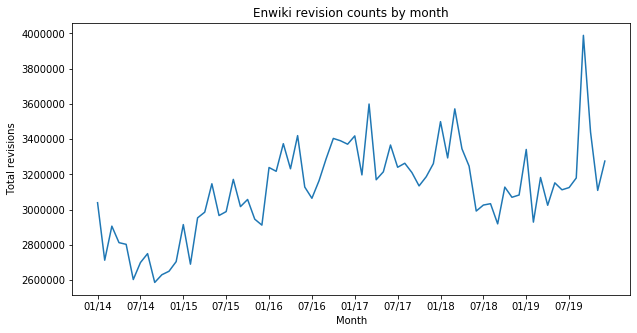

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plt.plot(range(len(month_revisions_list)-1), month_revisions_list[:-1])
plt.xticks(range(0, len(month_revisions_list)-1, 6), xtick_labels[:-1][::6])
plt.title("Enwiki revision counts by month")
plt.xlabel("Month")
plt.ylabel("Total revisions")
plt.show()

### Generate mock JSON

Generate mock JSON for use with `revscoring` and generate the appropriate revscoring bash script.


In [7]:
# now generate mock JSON for month samples
rev_ids_dir = os.path.join(working_dir, 'month_sample/rev_ids')
mock_json_dir = os.path.join(working_dir, 'month_sample/mock_json')
revscoring_scripts_dir = os.path.join(working_dir, 'month_sample/revscoring_scripts')
revscoring_cache_dir = os.path.join(working_dir, 'month_sample/revscoring_cache')
revscoring_features_dir = os.path.join(working_dir, 'month_sample/revscoring_features')

mock_template = '{"rev_id": %d, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}'
script_template = """#!/bin/bash
# Auto-generated script to use revscoring to extract features for a set of revisions

if [ -f {revscoring_features_filepath} ]; then
    echo "Skipping '$(basename {mock_json_filepath})' with existing features file."
else
    cat {mock_json_filepath} | revscoring extract editquality.feature_lists.enwiki.damaging editquality.feature_lists.enwiki.goodfaith --host https://en.wikipedia.org --extractors 32 --verbose > {revscoring_cache_filepath} \\
        || (echo "Failed to build feature caches" && exit 1)
    revscoring dump_cache --input {revscoring_cache_filepath} --output {revscoring_features_filepath} editquality.feature_lists.enwiki.damaging damaging \\
        || (echo "Failed to dump cache" && exit 1)
    echo "Successfully extracted '$(basename {mock_json_filepath})'."
fi
"""


revscoring_script_filepaths = []
for filename in tqdm(os.listdir(rev_ids_dir), total=72):
    if not filename.endswith(".txt"):
        continue
    rev_ids_filepath = os.path.join(rev_ids_dir, filename)
    rev_ids_list = []
    with open(rev_ids_filepath) as infile:
        for line in infile:
            if line.strip() != "":
                rev_ids_list.append(int(line.strip()))
    fname_base = os.path.splitext(filename)[0]
    mock_json_filepath = os.path.join(mock_json_dir, fname_base + ".mock.json")
    revscoring_script_filepath = os.path.join(revscoring_scripts_dir, fname_base + '_revscoring.sh')
    revscoring_cache_filepath = os.path.join(revscoring_cache_dir, fname_base + ".mock.w_cache.json")
    revscoring_features_filepath = os.path.join(revscoring_features_dir, fname_base + ".mock.damaging.tsv")
    with open(mock_json_filepath, 'w') as outfile:
        for rev_id in rev_ids_list:
            line = mock_template % rev_id
            outfile.write(line + "\n")
    
    script_text = script_template.format(
        mock_json_filepath=mock_json_filepath,
        revscoring_cache_filepath=revscoring_cache_filepath,
        revscoring_features_filepath=revscoring_features_filepath
    )
    with open(revscoring_script_filepath, 'w') as outfile:
        outfile.write(script_text)
    revscoring_script_filepaths.append(revscoring_script_filepath)

100%|██████████| 72/72 [00:10<00:00,  7.04it/s]


In [9]:
revscoring_all_script_base = """#!/bin/bash
# Auto-generated script that calls the sub-scripts to extract features for all month samples

cd /export/scratch2/levon003/repos/revscoring && conda activate wiki-revscoring
"""

revscoring_all_script = revscoring_all_script_base
for revscoring_script_filepath in revscoring_script_filepaths:
    revscoring_all_script += revscoring_script_filepath + " && \\ \n"
revscoring_all_script += 'echo "Success." && exit 0\n'
revscoring_all_script += 'echo "Failure." && exit 1\n'
revscoring_all_script_filepath = os.path.join(working_dir, "month_sample/revscoring_extract_all.sh")
with open(revscoring_all_script_filepath, 'w') as outfile:
    outfile.write(revscoring_all_script)
print("Finished.")

Finished.


Then, the permissions on all of these scripts should be manually set.

i.e. `chmod +x *.sh`